In [ ]:
import pandas as pd
import glob
import numpy as np
import json
import torch
import os
import seaborn as sns
from collections import Counter

In [ ]:
path = 'C:\\Users\\Asus\\Desktop\\dataset_2021'
input_dir = path+'\\paragraph_embedding_train'
data_path = glob.glob(input_dir+'\\*.pt')
label = glob.glob(path+'\\train\\*.txt')
len(data_path), len(label)

(11200, 11200)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(warm_start = True, random_state=100, n_estimators=100)

In [ ]:
n = len(data_path)
steps = n//30
prev_index = 0
rejected = 0
nan_docs = []
count_miss = 0
changes = []
for i in range(steps, n, steps):
    data = []
    labels = []
    for file_path in data_path[prev_index : i] :
        tensor_data = torch.load(file_path)
        document_id = file_path[len(input_dir)+16 : -3]
        data_label_path = path + '\\train' + '\\truth-problem-' + document_id + '.json'
        
        with open(data_label_path ) as file:
            label_list = json.load(file)['changes']
        nan = False;
        
        nan_tensor = []
        itr = 0
        if len(tensor_data) != len(label_list):
            count_miss +=1
            continue
        for tensor in tensor_data :
            if np.isnan(tensor.numpy()).any():
                nan_tensor.append(True)
                rejected +=1
                nan_docs.append(tensor)
            else:
                data.append(tensor)
                nan_tensor.append(False)
                labels.append(label_list[itr])
                changes.append(label_list[itr])
            itr +=1
                
        del label_list
        del tensor_data
    if len(labels) != len(data):
        print('Length mismatch ', len(labels), len(data))
        continue
    X = pd.DataFrame(data)
    y = labels
    clf.fit(X, y)
    clf.n_estimators +=10
    prev_index = i
    print(i)
    print(Counter(labels ))
    del X
    del y
    del data
    del labels
    


373
Counter({1: 1253, 0: 1005})
746
Counter({1: 1180, 0: 958})
1119
Counter({1: 1230, 0: 950})
1492
Counter({1: 1105, 0: 988})
1865
Counter({1: 1184, 0: 969})
2238
Counter({1: 1189, 0: 1002})
2611
Counter({1: 1150, 0: 1008})
2984
Counter({1: 1206, 0: 971})
3357
Counter({1: 1212, 0: 1052})
3730
Counter({1: 1169, 0: 1030})
4103
Counter({1: 1180, 0: 1013})
4476
Counter({1: 1152, 0: 1028})
4849
Counter({1: 1151, 0: 1038})
5222
Counter({1: 1165, 0: 969})
5595
Counter({1: 1106, 0: 1034})
5968
Counter({1: 1151, 0: 1020})
6341
Counter({1: 1140, 0: 1076})
6714
Counter({1: 1162, 0: 1073})
7087
Counter({1: 1153, 0: 1033})
7460
Counter({1: 1226, 0: 1038})
7833
Counter({1: 1174, 0: 1025})
8206
Counter({1: 1188, 0: 985})
8579
Counter({1: 1169, 0: 1095})
8952
Counter({1: 1202, 0: 995})
9325
Counter({1: 1234, 0: 1061})
9698
Counter({1: 1123, 0: 1049})
10071
Counter({1: 1210, 0: 1052})
10444
Counter({1: 1180, 0: 979})
10817
Counter({1: 1235, 0: 992})
11190
Counter({1: 1105, 0: 973})


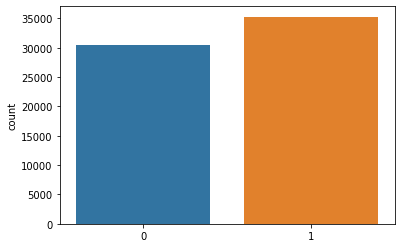

In [ ]:
sns.countplot(changes)

In [ ]:
import pickle
model_path = 'C:\\Users\Asus\\Desktop\\dataset_2021\\models\\para_classifier.p'
pickle.dump(clf, open(model_path, 'wb'))

In [ ]:
val_path = 'C:\\Users\\Asus\\Desktop\\dataset_2021\\validation_embedding'
val_dir = val_path+'\\paragraph_embedding'
val_data_path = glob.glob(val_dir+'\\*.pt')
len(val_data_path)

2400

In [ ]:
from sklearn.metrics import f1_score, classification_report
def predict(clf, x_test):
    val_data = []
    
    for tensor_data in x_test:
        val_df = pd.DataFrame(tensor_data)
        if not np.isnan(tensor_data.numpy()).any():
            val_data.append(tensor_data)
    val_df = pd.DataFrame(val_data)
    
    res = clf.predict(val_df) 
    res = res.tolist()
    del val_data
    del val_df
    return res

def accuracy_score(truth_data_path, pred_data_path):
    truth_data_path.sort()
    pred_data_path.sort()
    total = min(len(truth_data_path), len(pred_data_path))
    y_true = []
    y_pred = []
    for i in range(total):
        with open(truth_data_path[i], 'r') as file:
            truth = json.load(file)['changes']
            
        with open(pred_data_path[i], 'r') as file:
            pred = json.load(file)['changes']
            
        if len(truth) != len(pred):
            continue
        for x in truth:
            y_true.append(x)
        for x in pred:
            y_pred.append(x)
        
    return f1_score(y_true, y_pred), classification_report(y_true, y_pred)
            
    

In [ ]:
for val_path in val_data_path:
    val_tensor = torch.load(val_path)
    document_id = val_path[len(val_dir)+19:-3]
    dic = {}
    dic['changes'] = predict(clf, val_tensor)
    output_file_name = path + '\\para_output'+'\\solution-problem-' + document_id +'.json'
    with open(output_file_name, 'w') as output_file:
        json.dump(dic, output_file)
        


In [ ]:
truth_dir = 'C:\\Users\\Asus\\Desktop\\dataset_2021\\validation'
pred_dir = 'C:\\Users\\Asus\\Desktop\\dataset_2021\\para_output'
truth_data_path = glob.glob(truth_dir+'\\*.json')
pred_data_path = glob.glob(pred_dir +'\\*.json')

f1_score, classification_report = accuracy_score(truth_data_path, pred_data_path)

print(f1_score)
print(classification_report)



0.6564939673527325
              precision    recall  f1-score   support

           0       0.57      0.38      0.46      6372
           1       0.58      0.75      0.66      7417

    accuracy                           0.58     13789
   macro avg       0.58      0.56      0.56     13789
weighted avg       0.58      0.58      0.56     13789

